Epoch 0, Training loss: 0.5932748913764954, Test loss: 0.5873128771781921
Epoch 100, Training loss: 0.4234672486782074, Test loss: 0.4153028130531311
Epoch 200, Training loss: 0.3857763707637787, Test loss: 0.37755176424980164
Epoch 300, Training loss: 0.23643513023853302, Test loss: 0.229252889752388
Epoch 400, Training loss: 0.0865742564201355, Test loss: 0.08427979797124863
Epoch 500, Training loss: 0.04885651543736458, Test loss: 0.04759008437395096
Epoch 600, Training loss: 0.03292452543973923, Test loss: 0.03187482804059982
Epoch 700, Training loss: 0.020230745896697044, Test loss: 0.01944120042026043
Epoch 800, Training loss: 0.012026457116007805, Test loss: 0.011490832082927227
Epoch 900, Training loss: 0.007259482983499765, Test loss: 0.006920655723661184
Epoch 1000, Training loss: 0.00444314768537879, Test loss: 0.004234259016811848
Epoch 1100, Training loss: 0.002682855585590005, Test loss: 0.0025555898901075125
Epoch 1200, Training loss: 0.0015742653049528599, Test loss: 0.

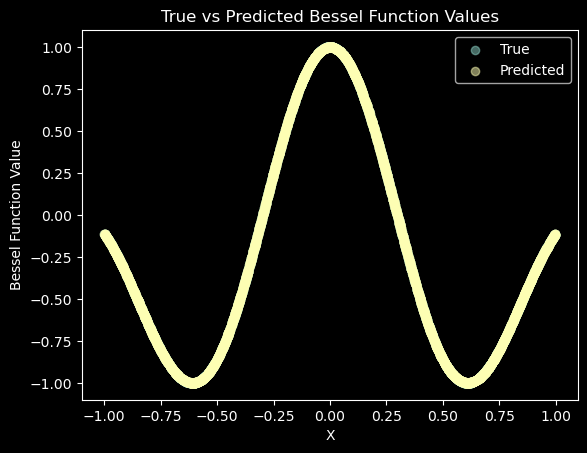

In [13]:
import numpy as np
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from scipy.special import jv
import matplotlib.pyplot as plt

def bessel(x):

    return jv(0, x)
x = np.linspace(-2*np.pi, 2* np.pi, 20000).reshape(-1, 1)
y = bessel(x).reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(-1,1))
x_scaled, y_scaled = scaler.fit_transform(x), scaler.fit_transform(y)

# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=0)

# Define the MLP model
class MLP(eqx.Module):
    layers: list

    def __init__(self, in_size, out_size, hidden_sizes, key):
        keys = jax.random.split(key, len(hidden_sizes) + 1)
        self.layers = []
        for in_size, out_size, key in zip([in_size] + hidden_sizes, hidden_sizes + [out_size], keys):
            self.layers.append(eqx.nn.Linear(in_size, out_size, key=key, use_bias=True))

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.tanh(layer(x))
        x = self.layers[-1](x)
        return x

# Training setup
key = jax.random.PRNGKey(0)
model = MLP(in_size=1, out_size=1, hidden_sizes=[16, 16], key=key)
optimizer = optax.adabelief(learning_rate=3e-4)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

# Loss function
@jax.jit
def compute_loss(model, X, y):
    pred = jax.vmap(model)(X)
    return jnp.mean((pred - y) ** 2)

# Training loop
@eqx.filter_jit
def train_step(model, optimizer, opt_state, X, y):
    loss, grads = eqx.filter_value_and_grad(compute_loss)(model, X, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

# Training
epochs = 10000
for epoch in range(epochs):
    loss, model, opt_state = train_step(model, optimizer, opt_state, x_train, y_train)
    if epoch % 100 == 0:
        test_loss = compute_loss(model, x_test, y_test)
        print(f"Epoch {epoch}, Training loss: {loss}, Test loss: {test_loss}")

# Prediction
preds = jax.vmap(model)(x_test)

# Visualization
plt.scatter(x_test, y_test, label="True", alpha=0.5)
plt.scatter(x_test, preds, label="Predicted", alpha=0.5)
plt.legend()
plt.xlabel("X")
plt.ylabel("Bessel Function Value")
plt.title("True vs Predicted Bessel Function Values")
plt.show()
